In [ ]:
!pip install transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


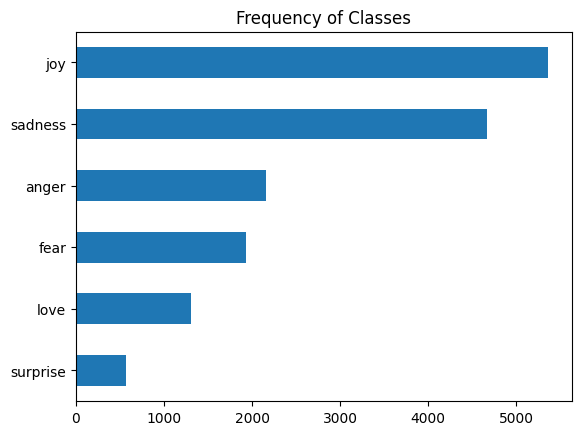

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
emotions.reset_format()

In [ ]:
from transformers import AutoTokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### Now Let's use a pretrained model to predict the labels

In [ ]:
from transformers import AutoModel
import torch

device = "cuda"
model = AutoModel.from_pretrained(model_name).to(device)

In [ ]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # Extract last_hidden_states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=3000)
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

0.633

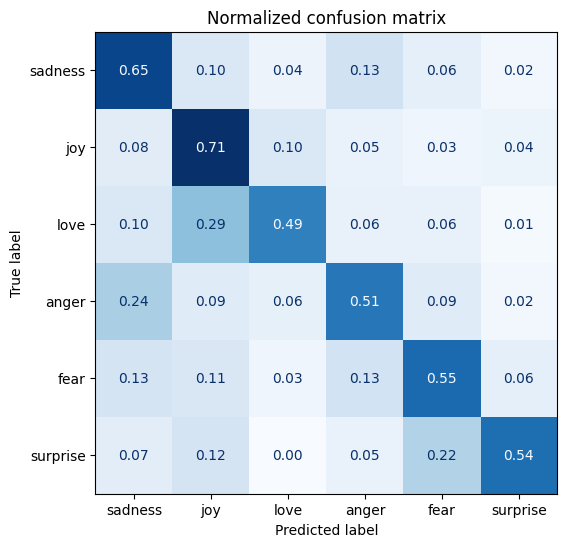

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = emotions["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_preds, y_true, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Finetunning a transformer model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

# Create id2label and label2id for the config file
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

config = AutoConfig.from_pretrained(model_name, num_labels=len(labels), label2id=label2id, id2label=id2label)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
_model_name = f"{model_name}-finetuned-emotion-detector-from-text"

training_args = TrainingArguments(output_dir=_model_name,
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.907500,0.514263,0.854000,0.836537


TrainOutput(global_step=250, training_loss=0.9075368041992188, metrics={'train_runtime': 114.4016, 'train_samples_per_second': 139.858, 'train_steps_per_second': 2.185, 'total_flos': 360171430848000.0, 'train_loss': 0.9075368041992188, 'epoch': 1.0})

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.16284196078777313,
 'test_accuracy': 0.9345,
 'test_f1': 0.9346813045403889,
 'test_runtime': 4.8885,
 'test_samples_per_second': 409.126,
 'test_steps_per_second': 6.546}

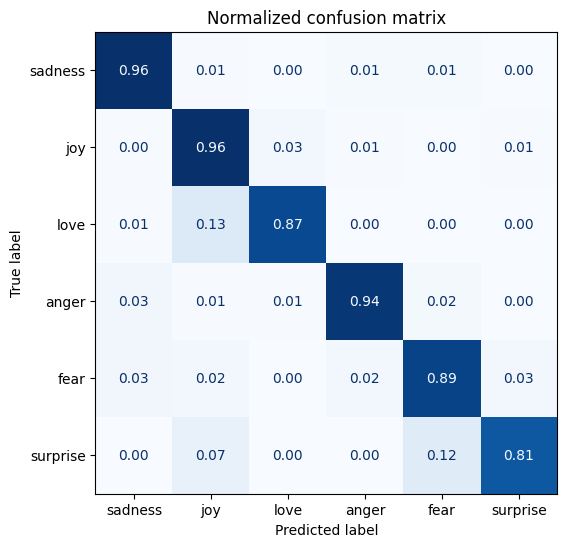

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.inference_mode():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,8.240818
318,i felt ashamed of these feelings and was scare...,fear,sadness,7.576676
882,i feel badly about reneging on my commitment t...,love,sadness,6.869376
1963,i called myself pro life and voted for perry w...,joy,sadness,6.711652
1111,im lazy my characters fall into categories of ...,joy,fear,6.655432
1870,i guess i feel betrayed because i admired him ...,joy,sadness,6.466440
1509,i guess this is a memoir so it feels like that...,joy,fear,6.343905
1801,i feel that he was being overshadowed by the s...,love,sadness,5.998427
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.984551
1919,i should admit when consuming alcohol myself i...,fear,sadness,5.730150


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.001043
702,i only find out that they are looking and feel...,joy,joy,0.001067
1028,im now winded at the end of a tough rally but ...,joy,joy,0.001093
1723,i know how much work goes into the creation an...,joy,joy,0.001103
632,i feel he is an terrific really worth bet,joy,joy,0.001106
752,i really do like the feeling of accomplishing ...,joy,joy,0.001117
1012,i definitely succumbed to pre holiday sales bu...,joy,joy,0.001119
1154,i love feeling carefree and without all these ...,joy,joy,0.001127
1622,i feel that it was a good investment to make t...,joy,joy,0.001129
578,i got to christmas feeling positive about the ...,joy,joy,0.001138


In [ ]:
trainer.push_to_hub(commit_message="Finetunning DistilBERT-text-emotion-detection-from-text Complete")

events.out.tfevents.1699205039.4c5c337ca0e2.307.2:   0%|          | 0.00/5.94k [00:00<?, ?B/s]

'https://huggingface.co/ali619/distilbert-base-uncased-finetuned-emotion-detector-from-text/tree/main/'

In [ ]:
emotions.reset_format()
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)